Importing the required libraries 

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import plotly.io as pio
pio.renderers.default = "browser"
import plotly.graph_objects as go

Loading the dataset and converting date column as index, as it is a timeseries data

In [2]:
bitcoin = pd.read_csv(r"C:\Users\Admin\Downloads\BTC-INR.csv")
bitcoin = bitcoin.set_index("Date")

In [3]:
bitcoin.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-08-22,15361.229492,15512.753906,14703.763672,15211.223633,15211.223633,1.532142e+09
2015-08-23,15210.299805,15364.068359,14893.648438,15064.584961,15064.584961,1.215274e+09
2015-08-24,15060.821289,15062.604492,14058.517578,14061.992188,14061.992188,3.956203e+09
2015-08-25,14033.465820,14989.896484,13331.954102,14688.354492,14688.354492,4.049023e+09
2015-08-26,14719.308594,15291.668945,14610.535156,14917.085938,14917.085938,2.101052e+09


In [4]:
bitcoin.shape

(1828, 6)

In [5]:
bitcoin.isnull().sum()

Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

Removing the null values

In [6]:
bitcoin = bitcoin.dropna()

In [7]:
bitcoin.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object

plotting the graph to show how High, Low, Open and Close prices in Our dataset changes along the date. x=Date y=INR

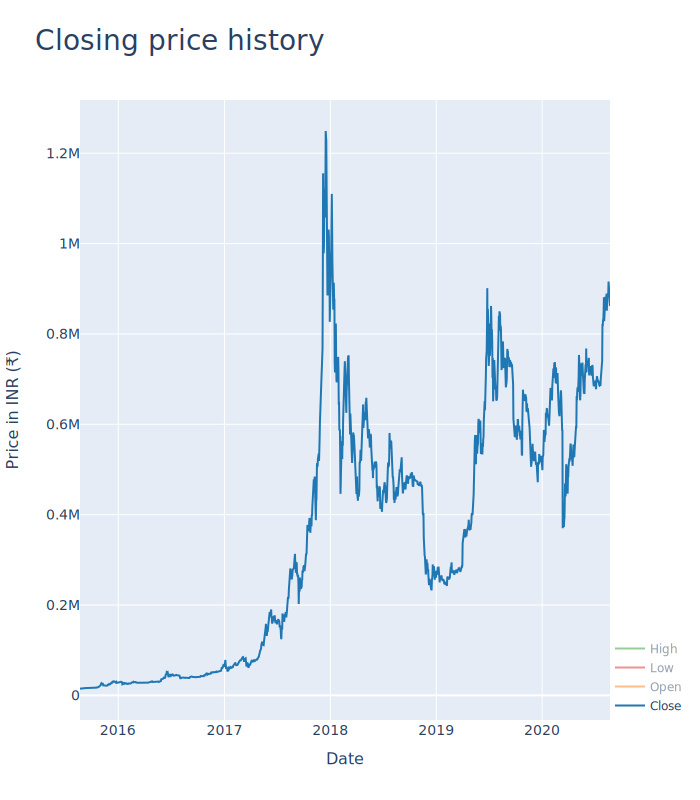

In [8]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = bitcoin.index, y = bitcoin.High,mode='lines',name='High',marker_color = '#2CA02C',visible = "legendonly"))
fig.add_trace(go.Scatter(x = bitcoin.index, y = bitcoin.Low,mode='lines',name='Low',marker_color = '#D62728',visible = "legendonly"))
fig.add_trace(go.Scatter(x = bitcoin.index, y = bitcoin.Open,mode='lines',name='Open',marker_color = '#FF7F0E',visible = "legendonly"))
fig.add_trace(go.Scatter(x = bitcoin.index, y = bitcoin.Close,mode='lines',name='Close',marker_color = '#1F77B4'))

fig.update_layout(title='Closing price history',titlefont_size = 28,
                  xaxis = dict(title='Date',titlefont_size=16,tickfont_size=14),height = 800,
                  yaxis=dict(title='Price in INR (₹)',titlefont_size=16,tickfont_size=14),
                  legend=dict(y=0,x=1.0,bgcolor='rgba(255, 255, 255, 0)',bordercolor='rgba(255, 255, 255, 0)'))
#fig.show()
fig.show(renderer="svg")

Normalizing the dataset using MinMaxScaler

In [9]:
values = bitcoin['Close'].values.reshape(-1,1) #coverting it into arrays
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(values)
scaled_data

array([[0.00093045],
       [0.00081173],
       [0.        ],
       ...,
       [0.70978957],
       [0.69187095],
       [0.68623676]])

Timeseries dataset can't be splitted using normal train_test_split function as their outputs are dependent, so taking the first 80% of data as train data and the remaining 20% (last part) test data.

In [10]:
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train, test = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:]
print(len(train), len(test))

1461 366


In [11]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back),0]
        dataX.append(a)
        dataY.append(dataset[i + look_back,0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [12]:
look_back = 1
x_train, y_train = create_dataset(train, look_back)
x_test, y_test = create_dataset(test, look_back)

1460
365


In [13]:
x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])

Building an LSTM model 

In [14]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (x_train.shape[1], 1), activation = 'tanh'))
model.add(LSTM(50, return_sequences = False, activation = 'tanh'))
model.add(Dense(25))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=5, batch_size=10)

Epoch 1/5
146/146 [==============================] - 28s 3ms/step - loss: 0.0404
Epoch 2/5
146/146 [==============================] - 1s 5ms/step - loss: 3.2426e-04
Epoch 3/5
146/146 [==============================] - 1s 4ms/step - loss: 3.3762e-04
Epoch 4/5
146/146 [==============================] - 1s 4ms/step - loss: 3.1674e-04
Epoch 5/5
146/146 [==============================] - 1s 3ms/step - loss: 3.4130e-04


Validating the model

In [15]:
predictions = model.predict(x_test)

mse = mean_squared_error(y_test, predictions)
rmse = math.sqrt(mse)
print(mse)
print(rmse)

0.0003530232221662743
0.01878891221349108


In [16]:
train = bitcoin[:train_size]
valid = bitcoin[train_size+1:]
predictions = scaler.inverse_transform(predictions)
valid['Predictions'] = predictions

<ipython-input-16-f40f13dfbca9>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



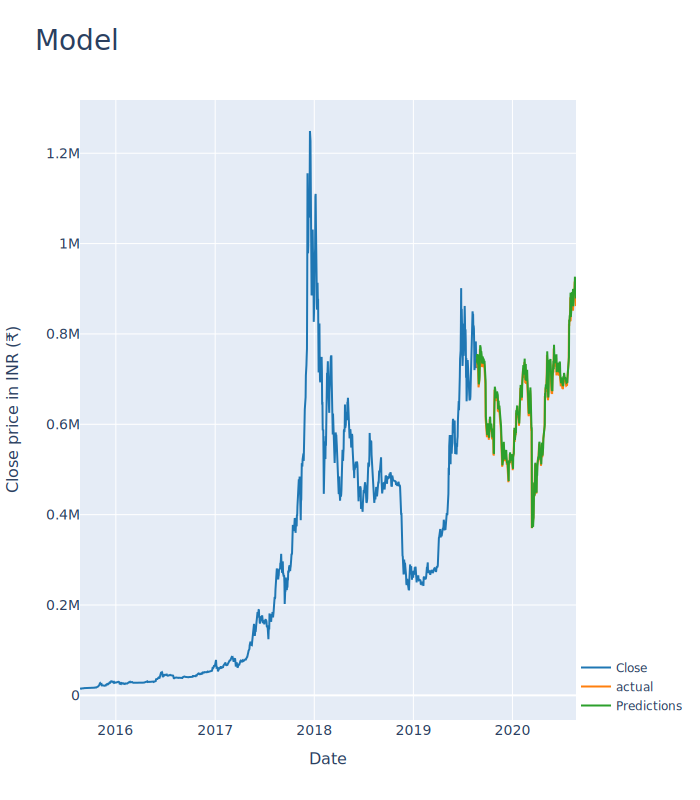

In [17]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = train.index, y = train.Close,mode='lines',name='Close',marker_color = '#1F77B4'))
fig.add_trace(go.Scatter(x = valid.index, y = valid.Close,mode='lines',name='actual',marker_color = '#FF7F0E'))
fig.add_trace(go.Scatter(x = valid.index, y = valid.Predictions,mode='lines',name='Predictions',marker_color = '#2CA02C'))

fig.update_layout(title='Model',titlefont_size = 28,hovermode = 'x',
                  xaxis = dict(title='Date',titlefont_size=16,tickfont_size=14),height = 800,
                  yaxis=dict(title='Close price in INR (₹)',titlefont_size=16,tickfont_size=14),
                  legend=dict(y=0,x=1.0,bgcolor='rgba(255, 255, 255, 0)',bordercolor='rgba(255, 255, 255, 0)'))
#fig.show()
fig.show(renderer="svg")

As you can see the predicted and actual prices are more or less the same